In [1]:
import os
import json
from web3 import Web3, HTTPProvider


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import datetime

In [2]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [3]:
pool_addr = "0x8301AE4fc9c624d1D396cbDAa1ed877821D7C511"
lp_token_addr = "0xEd4064f376cB8d68F770FB1Ff088a3d0F3FF5c4d"
tricrypto_addr = "0xD51a44d3FaE010294C616388b506AcdA1bfAAE46"

In [4]:
admin_2 = "0xA464e6DCda8AC41e03616F95f4BC98a13b8922Dc"
admin = "0xeCb456EA5365865EbAb8a2661B0c503410e9B347"

In [5]:
pool_addr.lower()

'0x8301ae4fc9c624d1d396cbdaa1ed877821d7c511'

In [6]:
with open("./crveth.json", 'r') as f:
    abi = json.load(f)
crveth = web3.eth.contract(address=pool_addr, abi=abi)

with open("../tricrypto/tricrypto2.json", 'r') as f:
    abi = json.load(f)
tricrypto2 = web3.eth.contract(address=tricrypto_addr, abi=abi)

In [7]:
start_block = 13676983
current_block = web3.eth.get_block_number()

In [8]:
datetime.datetime.fromtimestamp(web3.eth.getBlock(13685675)['timestamp'])

datetime.datetime(2021, 11, 25, 21, 50, 4)

In [9]:
fees_for_range = []

transfer_filter = crveth.events.ClaimAdminFee.createFilter(
    fromBlock=start_block,
    toBlock=current_block
)
all_transfers = transfer_filter.get_all_entries()
claimed_lp_tokens = 0
for transfer in all_transfers:

    value = transfer['args']['tokens']
    block = transfer['blockNumber']
    tx_hash = transfer['transactionHash'].hex()
    claimed_lp_tokens = value * 1e-18
    lp_token_price = crveth.functions.lp_price().call(block_identifier=block) * 1e-18
    eth_price = tricrypto2.functions.price_oracle(1).call(block_identifier=block) * 1e-18
    timestamp = datetime.datetime.fromtimestamp(web3.eth.getBlock(block)['timestamp'])

    dict_fees = {
        'block': block,
        'timestamp': timestamp,
        'lp_tokens': claimed_lp_tokens,
        'lp_token_price': lp_token_price,
        'eth_price': eth_price,
        'total_claimed_eth': claimed_lp_tokens * lp_token_price,
        'total_claimed_usd': claimed_lp_tokens * lp_token_price * eth_price,
        'tx_hash': tx_hash
    }
    fees_for_range.append(dict_fees)

df_fees = pd.DataFrame(fees_for_range)
df_fees

,block,timestamp,lp_tokens,lp_token_price,eth_price,total_claimed_eth,total_claimed_usd,tx_hash
0,13679936,2021-11-24 23:52:07,0.907424,0.072970,4258.862428,0.066215,281.999560,0x84455bc2bfe64b3b3f7d376509627a4b2f49e829471a...
1,13680249,2021-11-25 01:06:08,0.067634,0.074352,4261.559880,0.005029,21.430230,0x736ccb2e6039d7650bcdb0db5a970ffe961bcca9aa39...
2,13680817,2021-11-25 03:12:00,0.097719,0.072750,4324.233635,0.007109,30.741352,0x7003bee5457010bce410b952ba38edd5697ed68633fa...
3,13682288,2021-11-25 08:56:23,0.146441,0.073215,4297.494835,0.010722,46.075944,0xb37003fedfcb87660dfeb52171ac87184e2f769f7575...
4,13682643,2021-11-25 10:21:04,0.214296,0.075104,4292.258684,0.016095,69.082095,0x5afffade8fef840400568dccbbc037cf084adb23cdd3...
...,...,...,...,...,...,...,...,...
1283,13927064,2022-01-02 17:15:07,0.744184,0.080325,3779.673297,0.059777,225.937016,0xa92247c2074cbc04dfa882d10cb31252754db6bbc083...
1284,13927065,2022-01-02 17:15:21,0.182114,0.080332,3779.673297,0.014630,55.294918,0xb58c2fcfb69a19c204fd485634c1341b82ef619ce309...
1285,13927069,2022-01-02 17:16:29,0.000052,0.080368,3779.673297,0.000004,0.015793,0xea91492600b25bc9af941630821f149a6b96bd83e773...
1286,13927104,2022-01-02 17:24:34,0.342164,0.080515,3779.673297,0.027549,104.127387,0x315e31bdf312724767255b69505952ffb6c0c5a2afce...


In [10]:
print(df_fees.where(df_fees.total_claimed_usd == df_fees.total_claimed_usd.max()).tx_hash.dropna().values[0])

0x431cec6f2b68afae27b58005d07493e7f2aed1759689ad97f07106ba9fdf014c


In [11]:
df_fees.set_index('timestamp', inplace=True)

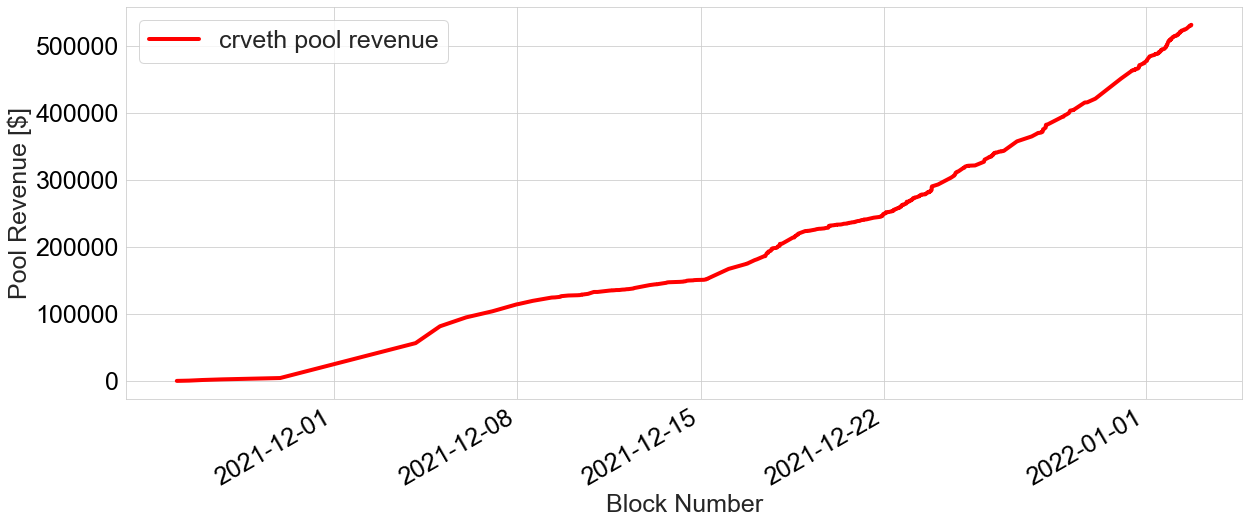

In [12]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

(df_fees['total_claimed_usd']*2).cumsum().plot(
    ax=ax,
    color='red',
    label='crveth pool revenue',
    lw=4
)

ax.set_ylabel("Pool Revenue [$]", fontsize=25)
ax.set_xlabel("Block Number", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.legend(fontsize=25);

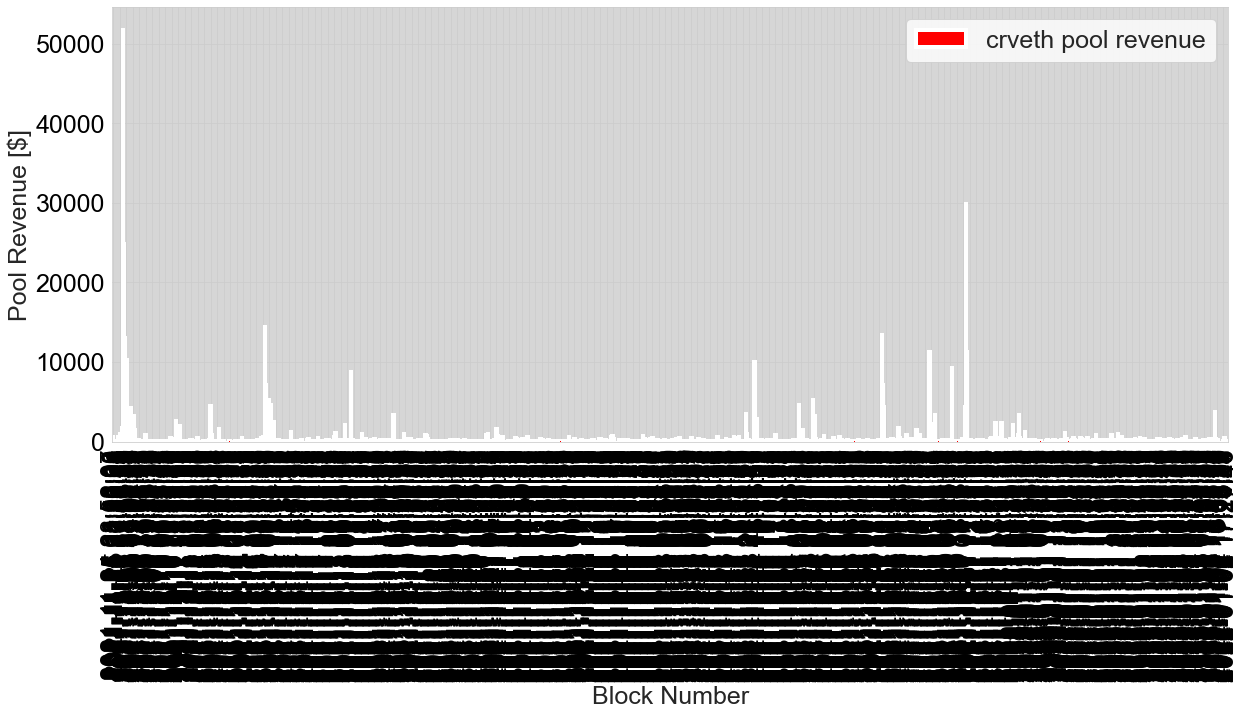

In [13]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

(df_fees['total_claimed_usd']*2).plot(
    ax=ax,
    color='red',
    label='crveth pool revenue',
    lw=4,
    kind='bar'
)

ax.set_ylabel("Pool Revenue [$]", fontsize=25)
ax.set_xlabel("Block Number", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.legend(fontsize=25);